In [1]:
pip install numpy pandas matplotlib yfinance scipy

In [3]:
import yfinance as yf
import pandas as pd

# Define the list of tickers
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA"]

# Download historical data
data = yf.download(tickers, start="2020-01-01", end="2023-01-01")

# Access the 'Close' column instead of 'Adj Close'
# If 'Adj Close' is available, use that, otherwise use 'Close'
data = data['Close'] if 'Close' in data else data['Adj Close'] if 'Adj Close' in data else data

# Display the first few rows
print(data.head())


[*********************100%***********************]  5 of 5 completed

Ticker           AAPL       AMZN      GOOGL        MSFT       TSLA
Date                                                              
2020-01-02  72.716072  94.900497  68.108368  153.323257  28.684000
2020-01-03  72.009117  93.748497  67.752075  151.414124  29.534000
2020-01-06  72.582901  95.143997  69.557945  151.805481  30.102667
2020-01-07  72.241547  95.343002  69.423584  150.421371  31.270666
2020-01-08  73.403648  94.598503  69.917732  152.817322  32.809334


In [4]:
# Calculate daily returns
returns = data.pct_change().dropna()

# Calculate the covariance matrix
cov_matrix = returns.cov() * 252  # Annualized covariance
print(cov_matrix)

Ticker      AAPL      AMZN     GOOGL      MSFT      TSLA
Ticker                                                  
AAPL    0.136407  0.095733  0.093136  0.104155  0.138480
AMZN    0.095733  0.152759  0.091682  0.095278  0.134639
GOOGL   0.093136  0.091682  0.119187  0.099620  0.112748
MSFT    0.104155  0.095278  0.099620  0.120806  0.125667
TSLA    0.138480  0.134639  0.112748  0.125667  0.521113


In [5]:
import numpy as np

def portfolio_performance(weights, returns, cov_matrix):
    """
    Calculate portfolio return, risk, and Sharpe ratio.
    """
    portfolio_return = np.sum(returns.mean() * weights) * 252
    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = portfolio_return / portfolio_risk
    return portfolio_return, portfolio_risk, sharpe_ratio

def optimize_portfolio(returns, cov_matrix, risk_free_rate=0.02):
    """
    Optimize the portfolio using Modern Portfolio Theory.
    """
    num_assets = len(returns.columns)
    args = (returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # Weights sum to 1
    bounds = tuple((0, 1) for _ in range(num_assets))  # No short selling
    initial_guess = num_assets * [1. / num_assets]  # Equal weights

    # Maximize Sharpe ratio
    from scipy.optimize import minimize
    result = minimize(lambda x: -portfolio_performance(x, *args)[2], initial_guess,
                     method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

In [6]:
# Optimize the portfolio
optimal_weights = optimize_portfolio(returns, cov_matrix)

# Display optimal weights
print("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.2%}")

# Calculate portfolio performance
optimal_return, optimal_risk, optimal_sharpe = portfolio_performance(optimal_weights, returns, cov_matrix)
print(f"Optimal Portfolio Return: {optimal_return:.2%}")
print(f"Optimal Portfolio Risk: {optimal_risk:.2%}")
print(f"Optimal Sharpe Ratio: {optimal_sharpe:.2f}")

Optimal Weights:
AAPL: 31.80%
MSFT: 0.00%
GOOGL: 0.00%
AMZN: 0.00%
TSLA: 68.20%
Optimal Portfolio Return: 59.15%
Optimal Portfolio Risk: 56.23%
Optimal Sharpe Ratio: 1.05


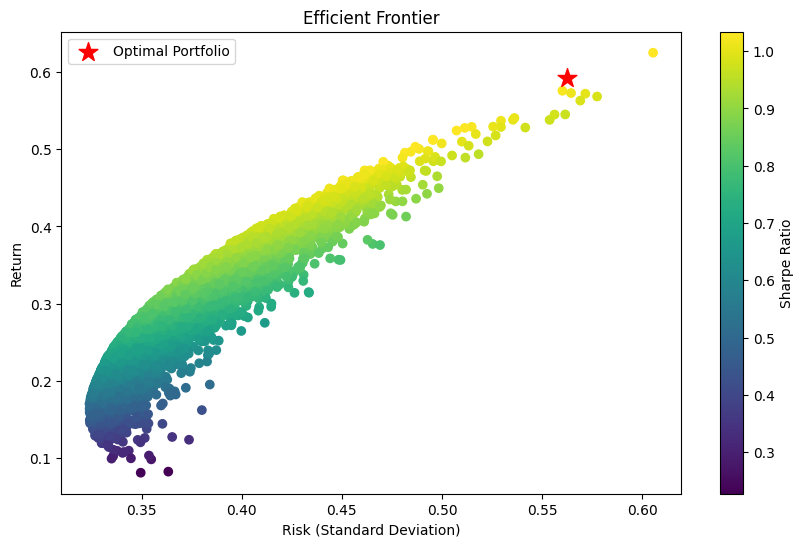

In [7]:
import matplotlib.pyplot as plt

# Simulate random portfolios
num_portfolios = 10000
results = np.zeros((3, num_portfolios))

for i in range(num_portfolios):
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)
    portfolio_return, portfolio_risk, sharpe_ratio = portfolio_performance(weights, returns, cov_matrix)
    results[0, i] = portfolio_return
    results[1, i] = portfolio_risk
    results[2, i] = sharpe_ratio

# Plot the efficient frontier
plt.figure(figsize=(10, 6))
plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap="viridis", marker="o")
plt.colorbar(label="Sharpe Ratio")
plt.scatter(optimal_risk, optimal_return, c="red", marker="*", s=200, label="Optimal Portfolio")
plt.title("Efficient Frontier")
plt.xlabel("Risk (Standard Deviation)")
plt.ylabel("Return")
plt.legend()
plt.show()

In [8]:
# Baseline portfolio (equal weights)
baseline_weights = np.array([1/len(tickers)] * len(tickers))
baseline_return, baseline_risk, baseline_sharpe = portfolio_performance(baseline_weights, returns, cov_matrix)

# Compare results
print(f"Baseline Portfolio Return: {baseline_return:.2%}")
print(f"Baseline Portfolio Risk: {baseline_risk:.2%}")
print(f"Baseline Sharpe Ratio: {baseline_sharpe:.2f}")

improvement = (optimal_sharpe - baseline_sharpe) / baseline_sharpe * 100
print(f"Improvement in Sharpe Ratio: {improvement:.2f}%")

Baseline Portfolio Return: 27.77%
Baseline Portfolio Risk: 35.96%
Baseline Sharpe Ratio: 0.77
Improvement in Sharpe Ratio: 36.19%
